This notebook generates the data used for Fig. 2 in M. Nägele, C. Schweizer, F. Roy, S. Filipp, Effective non-local parity-dependent couplings in qubit chains (2022), https://arxiv.org/abs/2203.07331

In [1]:
import qutip as qt
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import numpy as np

In [2]:
def buildH15(gamma: float) -> qt.Qobj:
    """gamma: between 0 and 1, scales transfer angle of FST,
    returns QuTip hamiltonian of FST for a chain with 15 sites"""
    N = 15
    a = qt.destroy(2)
    Id = qt.qeye(2)

    # List of annihilation operators for each qubit
    a_list = [qt.tensor([Id] * i + [a] + [Id] * (N - i - 1))  for i in range(N)]

    # List of detunings between qubits
    B_list =  [(gamma - 1) * N / 4 * (1 / (2 * n - N) - 1 / (2 * n - 2  - N) )   for n in range(1, N+1)]
    # List of couplings between qubits
    J_list = [np.sqrt( ( n * (N - n) * ( (2 * n - N)**2 - (gamma - 1)**2) ) / (2 * n - N)**2 ) / 2 for n in range(1, N)]  

    H = B_list[N-1] * a_list[N-1].dag() * a_list[N-1]
    for i in range(0, N-1):
        H += B_list[i] * a_list[i].dag() * a_list[i]
        H += J_list[i] * (a_list[i].dag() * a_list[i+1] + a_list[i] * a_list[i+1].dag())
    return H

def build_multi_colormap(steps:list, colors:list)-> mcolors.LinearSegmentedColormap:
    """steps: ordered list with values between 0 and 1, determines location of color in colorbar
    colors: list of colors with  for each step, a color is specified by an array with 3 values between 0 and 1(RGB)
    returns LinearSegmentedColormap """
    cdict ={
        "red": [],
        "green": [],
        "blue": [],
        }
    for step, col in zip(steps, colors):
        cdict["red"].append((step, col[0], col[0]))
        cdict["green"].append((step, col[1], col[1]))
        cdict["blue"].append((step, col[2], col[2]))
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

In [3]:
N = 15
lvls=2
# Build hamiltonian with theta = pi/2
H = buildH15(0.5)

a = qt.destroy(lvls)
Id = qt.qeye(lvls)

a_list = [qt.tensor([Id] * i + [a] + [Id] * (N - i - 1))  for i in range(N)]

# Create list of excitation number operators of each site
op_list_exc = []
for i in range(N):
    op = a_list[i].dag() * a_list[i]
    op_list_exc.append(op)

opt = qt.solver.Options(store_states=True)

In [4]:
# Two FST with one excitation
psi1=qt.basis([lvls]*N , [1] + [0]*(N-1))
t_two = np.linspace(0, 2 * np.pi, 2000)
output1 = qt.sesolve(H, psi1, t_two, e_ops=op_list_exc, options=opt)

# First FST with two excitations
psi18=qt.basis([lvls]*N , [1, 0, 0, 0, 0, 0, 0, 1] + [0]*(N-8))
t_one = np.linspace(0, np.pi, 1000)
output18 = qt.sesolve(H, psi18, t_one, e_ops=op_list_exc, options=opt)
 

In [5]:
# Flip state of middle qubit after first FST
x_8 = (a_list[7] + a_list[7].dag()) 
psi_flipped = (x_8 * output18.states[-1])

In [6]:
# Second FST after X gate
output_flipped = qt.sesolve(H, psi_flipped, t_one, e_ops=op_list_exc, options=opt  )

<ipython-input-7-784bce181634>:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


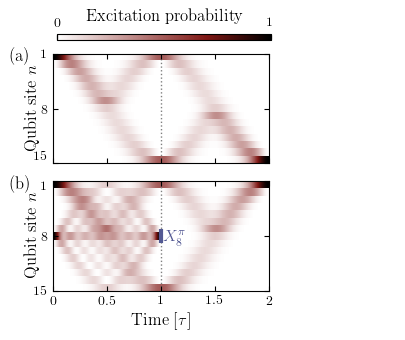

In [7]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"]})



# Build colormap
black = (0.,0.,0.)
white = (1.,1.,1.)
red_dark = np.array((128, 24, 21))/256


steps = [0., 0.7, 1.]
colors= [white, red_dark, black]
cm = build_multi_colormap(steps, colors)



fig = plt.figure(figsize=((4.11, 3.11)), dpi=100)

# Fonstsize
s=12
# Ticksize
st=10

ds = -0.2
dz = 1.05


gs = gridspec.GridSpec(2, 2, width_ratios=[2,1])
              
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[1])
ax4 = plt.subplot(gs[3])


ax1.label_outer()
ax2.label_outer()




# FIG1 ------------------
ax = ax1
im = ax.imshow(np.array(output1.expect), aspect="auto", cmap=cm, interpolation="nearest")

ax.set_yticks([-0.5, 7, 14.5])
ax.set_yticklabels([1,8, 15])
ax.get_yaxis().majorTicks[2].label1.set_verticalalignment('bottom')

ax.set_xticks([-0.5, 499, 999, 1499, 1999.5])

ax.tick_params(labelright=False, labelbottom=False, labelsize=st, right=True, left = True, top = True, direction='in')

ax.axvline(1000, c='gray', ls=":", lw=1, zorder=1)


ax.text(ds, dz, r"(a)", transform=ax.transAxes,
      fontsize=s, va='top')

ax.set_ylabel(r"Qubit site $n$", size = s, labelpad=-3)



# FIG2 ------------------
ax = ax2
im = ax.imshow(np.append(np.array(output18.expect), np.array(output_flipped.expect), axis=1), aspect="auto", cmap=cm, interpolation="nearest")

ax.set_yticks([-0.5, 7, 14.5])
ax.set_yticklabels([1, 8, 15])
ax.get_yaxis().majorTicks[0].label1.set_verticalalignment('top')

ax.set_xticks([-0.5, 499, 999, 1499, 1999.5])
ax.set_xticklabels([0, 0.5,  1, 1.5, 2])

ax.tick_params(labelright=False, labelbottom=True, labelsize=st, right=True, left = True, top = True, direction='in')

ax.vlines(1000, 6, 8, color="#535993", linewidths=3)

ax.axvline(1000, c='gray', ls=":", lw=1, zorder=1)

ax.set_xlabel(r"Time [$\tau$]", size = s)

ax.text(ds, dz, r"(b)", transform=ax.transAxes,
      fontsize=s, va='top')

ax.set_ylabel(r"Qubit site $n$", size = s, labelpad=-3)

ax.text(0.51, 0.55, r"$X^\pi_8$", transform=ax.transAxes,
      fontsize=s, va='top', color = "#535993")


# Colorbar
fig.subplots_adjust(top=0.5)
cbar_ax = fig.add_axes([0.14, 0.98, 0.52, 0.02])
cbar = fig.colorbar(im, cax=cbar_ax, orientation="horizontal")
cbar.set_label(r"Excitation probability", size = s, rotation=0, labelpad=-22)
cbar.set_ticks([0, 1])
cbar.ax.tick_params(labelsize=st, right=True, direction='in', top = True, bottom = True, labelbottom = False, labeltop=True)

ax3.axis('off')
ax4.axis('off')

fig.tight_layout()

#plt.savefig("fig2.pdf", bbox_inches="tight")